### Last updated January 11, 2024 by Annabel Wade

In [18]:
# External imports
import numpy as np, xarray as xr, matplotlib.pyplot as plt, os, string
from tabulate import tabulate; from os.path import join
from QC_functions import *; from QC_hand_pick_pnts import hp_TEMP, hp_PSAL

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'

main_dir = os.getcwd()
subdirs = ["data_dir", "figures_dir", "flag_array_dir"]
data_dir, figures_dir, flag_array_dir = [join(main_dir, subdir) for subdir in subdirs]

import matplotlib.cbook as cbook
maxnum=80

### Plotting hand picked points

In [23]:
# Remove any filenums have only PSAL <10 in their hand picked points
filenums = np.array(list(hp_PSAL.keys())).flatten()
i = 0
for filenum in filenums:
    nc = join(data_dir, 'global_profiles.{:02d}.nc'.format(filenum) )
    data = xr.open_dataset(nc)
    
    inds_to_drop = []
    for ind in range(len(hp_PSAL[filenum])):
        (sample_i,cyc_i) = hp_PSAL[filenum][ind]
        PSAL = data.PSAL.isel(cycle=cyc_i)
        if PSAL.isel(sample=sample_i) < 10:
            inds_to_drop.append(ind)

    # Drop hp points under 10 PSAL
    hp_PSAL[filenum] = np.delete(hp_PSAL[filenum],inds_to_drop,axis=0)

    if hp_PSAL[filenum].size == 0:
        # Remove the filenum from the dictionary if all hp points removed
        hp_PSAL.pop(filenum)
        print('filenum',filenum, 'has no hand picked points left after dropping OOR PSAL')

PSAL_filenums = np.sort(np.array(list(hp_PSAL.keys())).flatten())
num_PSAL_files = len(filenums)
print(num_PSAL_files, 'unique filenums w hp_PSAL')

TEMP_filenums = np.array(list(hp_TEMP.keys())).flatten()
num_TEMP_files = len(TEMP_filenums)
print(num_TEMP_files, 'unique filenums w hp_TEMP')


15 unique filenums w hp_PSAL
3 unique filenums w hp_TEMP


16 plotted
17 plotted
32 plotted
2 plotted
12 plotted
13 plotted
14 plotted
15 plotted
16 plotted
17 plotted
20 plotted
37 plotted
40 plotted
46 plotted
48 plotted
62 plotted
67 plotted
78 plotted


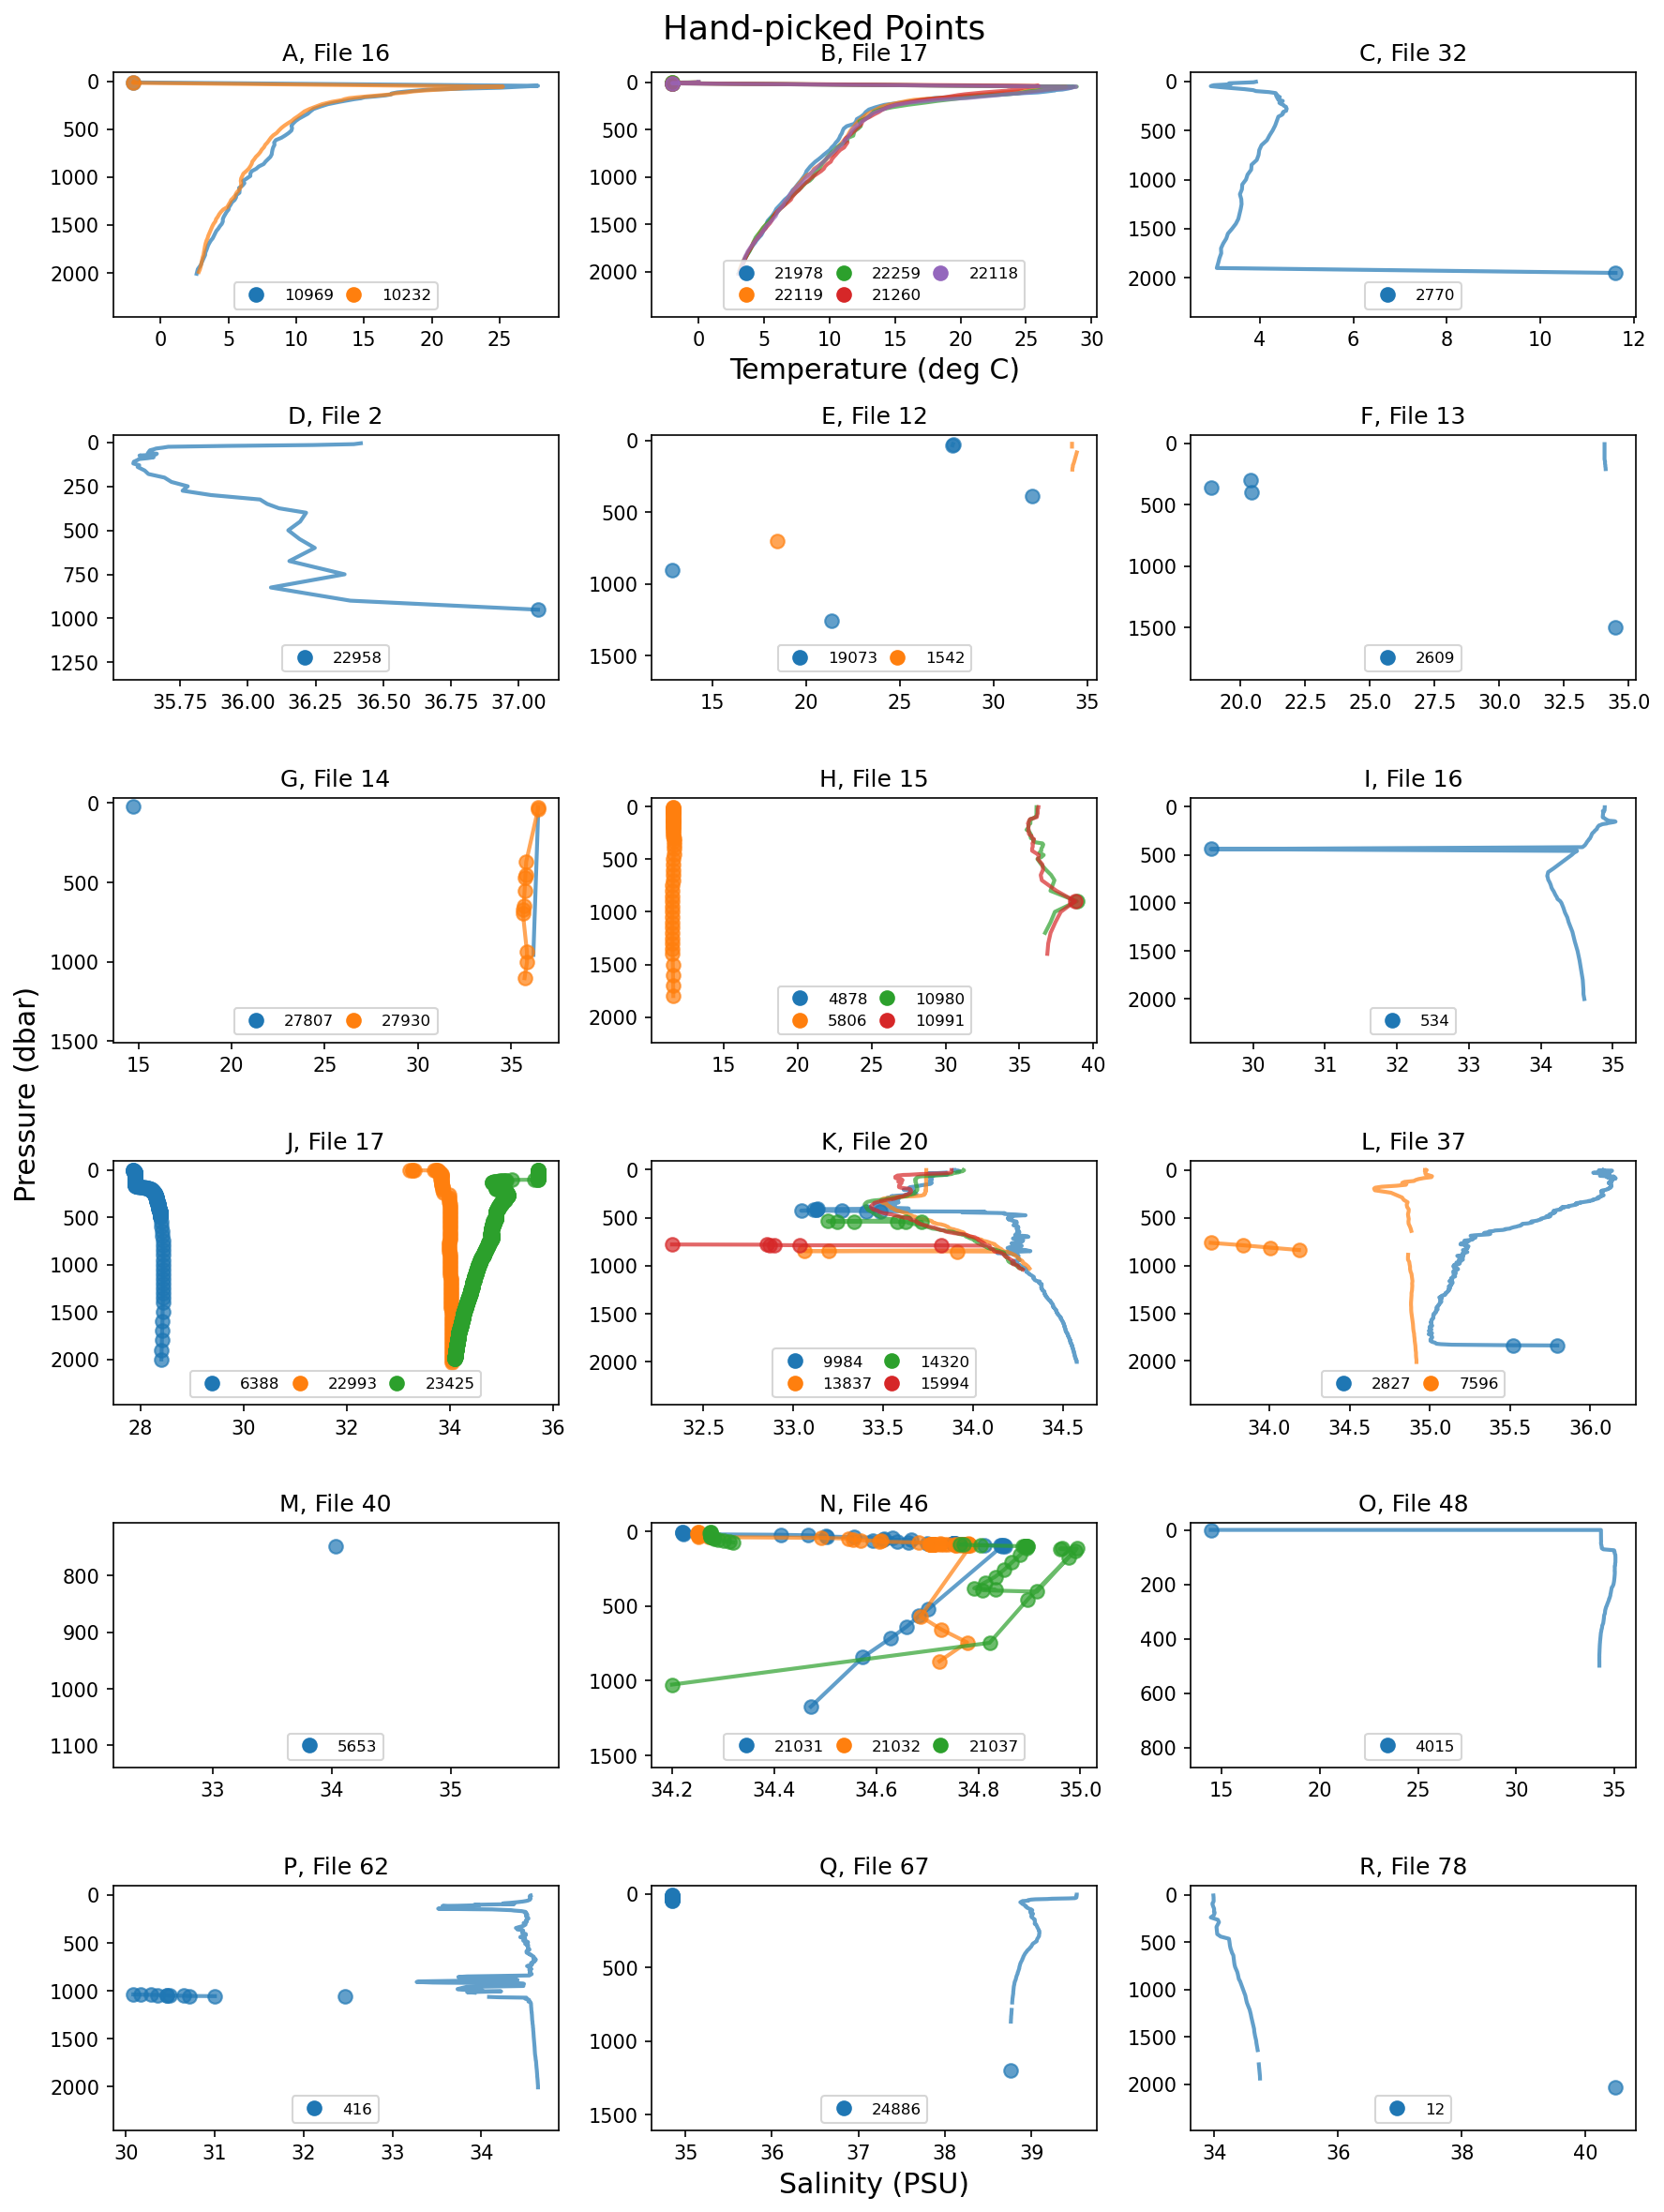

In [30]:
# Plot hand-picked points
fig,ax = plt.subplots(6,3, figsize=(12,16)) 
fig_fp = join(figures_dir, 'hp_pnts_figs/hp_PSAL_TEMP_6x3.png')

# make an array of indices to iterate through the axes which is 5x3
axes_inds = np.array([(i,j) for i in range(6) for j in range(3)])

# combine the TEMP and PSAL filenums into one array
total_files = np.concatenate((TEMP_filenums,PSAL_filenums))

# generate array of letters to use for subplot titles
letters = np.array(list(string.ascii_uppercase)[:len(total_files)])	

for file_i, filenum in enumerate(total_files):
	nc = join( data_dir, 'global_profiles.{:02d}.nc'.format(filenum) )
	data = xr.open_dataset(nc)
	i=0
	row,col = axes_inds[file_i]

	plotted_cycs = []

	# PSAL
	if file_i >= len(TEMP_filenums):
		for (sample_i,cyc_i) in hp_PSAL[filenum]:
			PSAL = data.PSAL.isel(cycle=cyc_i)
			if np.any(PSAL < 10):
				# Make PSAL points under 10 to be NaN so they don't plot
				arr = PSAL.values
				arr[arr < 10] = np.nan 
				data.PSAL.loc[dict(cycle=cyc_i)] = arr

			if not cyc_i in plotted_cycs:
				plotted_cycs.append(cyc_i)
				prof = ax[row,col].plot(data['PSAL'].isel(cycle=cyc_i),
							data['PRES'].isel(cycle=cyc_i),
							'-',
							lw=2,
							label=str(cyc_i), 
							# color=cyc_colors[i]
							alpha=0.7,
							)
				curr_cyc_color = prof[0].get_color()
				i+=1
			point = ax[row,col].plot(data['PSAL'].isel(cycle=cyc_i).isel(sample=sample_i),
					data['PRES'].isel(cycle=cyc_i).isel(sample=sample_i),
					'o', 
					# markeredgecolor='k',
					# markeredgewidth=0.5,
					# label=str(cyc_i), 
					c=curr_cyc_color, 
					alpha=0.7,
					markersize=7)
	# TEMP
	else:
		for (sample_i,cyc_i) in hp_TEMP[filenum]:
			TEMP = data.TEMP.isel(cycle=cyc_i)

			if not cyc_i in plotted_cycs:
				plotted_cycs.append(cyc_i)
				prof = ax[row, col].plot(data['TEMP'].isel(cycle=cyc_i),
							data['PRES'].isel(cycle=cyc_i),
							'-',
							lw=2,
							label=str(cyc_i), 
							# color=cyc_colors[i]
							alpha=0.7,
							)
				curr_cyc_color = prof[0].get_color()
				i+=1
			point = ax[row, col].plot(data['TEMP'].isel(cycle=cyc_i).isel(sample=sample_i),
					data['PRES'].isel(cycle=cyc_i).isel(sample=sample_i),
					'o', 
					c=curr_cyc_color, 
					alpha=0.7,
					markersize=7)

		
	ax[row,col].set_title(letters[file_i] + ', File '+ str(filenum), fontsize='large')

	# Add a little bit of vertical space to the bottom of the plot to have room for legend
	# print(ax[row,col].get_ylim())
	ax[row,col].set_ylim([ax[row,col].get_ylim()[0],ax[row,col].get_ylim()[1] + 350])
	ax[row,col].invert_yaxis()
	cols = 0
	if i == 1: cols = 1
	if i == 2 or i == 4: cols = 2
	if i == 3 or i==5: cols = 3

	ax[row,col].legend(loc='lower center', 
				ncols=cols,
				# nrows=2,
				prop={'size': 8},
				columnspacing=0.25,
				# title='Cycle index', 
			#   title_fontsize='large', fontsize='large'
				)
				
	# change legend elements to circles instead of lines
	leg = ax[row,col].get_legend()
	for lh in leg.legend_handles: 
		lh.set_alpha(1)
		lh.set_linestyle('')
		lh.set_marker('o')
		lh.set_markersize(7)

	print(filenum, 'plotted')

# make title under the first row 
ax[0,1].set_xlabel('Temperature (deg C)', fontsize='x-large')

ax[5,1].set_xlabel('Salinity (PSU)', fontsize='x-large')
fig.supylabel('Pressure (dbar)', fontsize='x-large')
fig.suptitle("Hand-picked Points", fontsize='xxx-large')

plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(fig_fp, dpi=300)
plt.show()

2 plotted
12 plotted
13 plotted
14 plotted
15 plotted
16 plotted
17 plotted
20 plotted
37 plotted
40 plotted
46 plotted
48 plotted
62 plotted
67 plotted
78 plotted


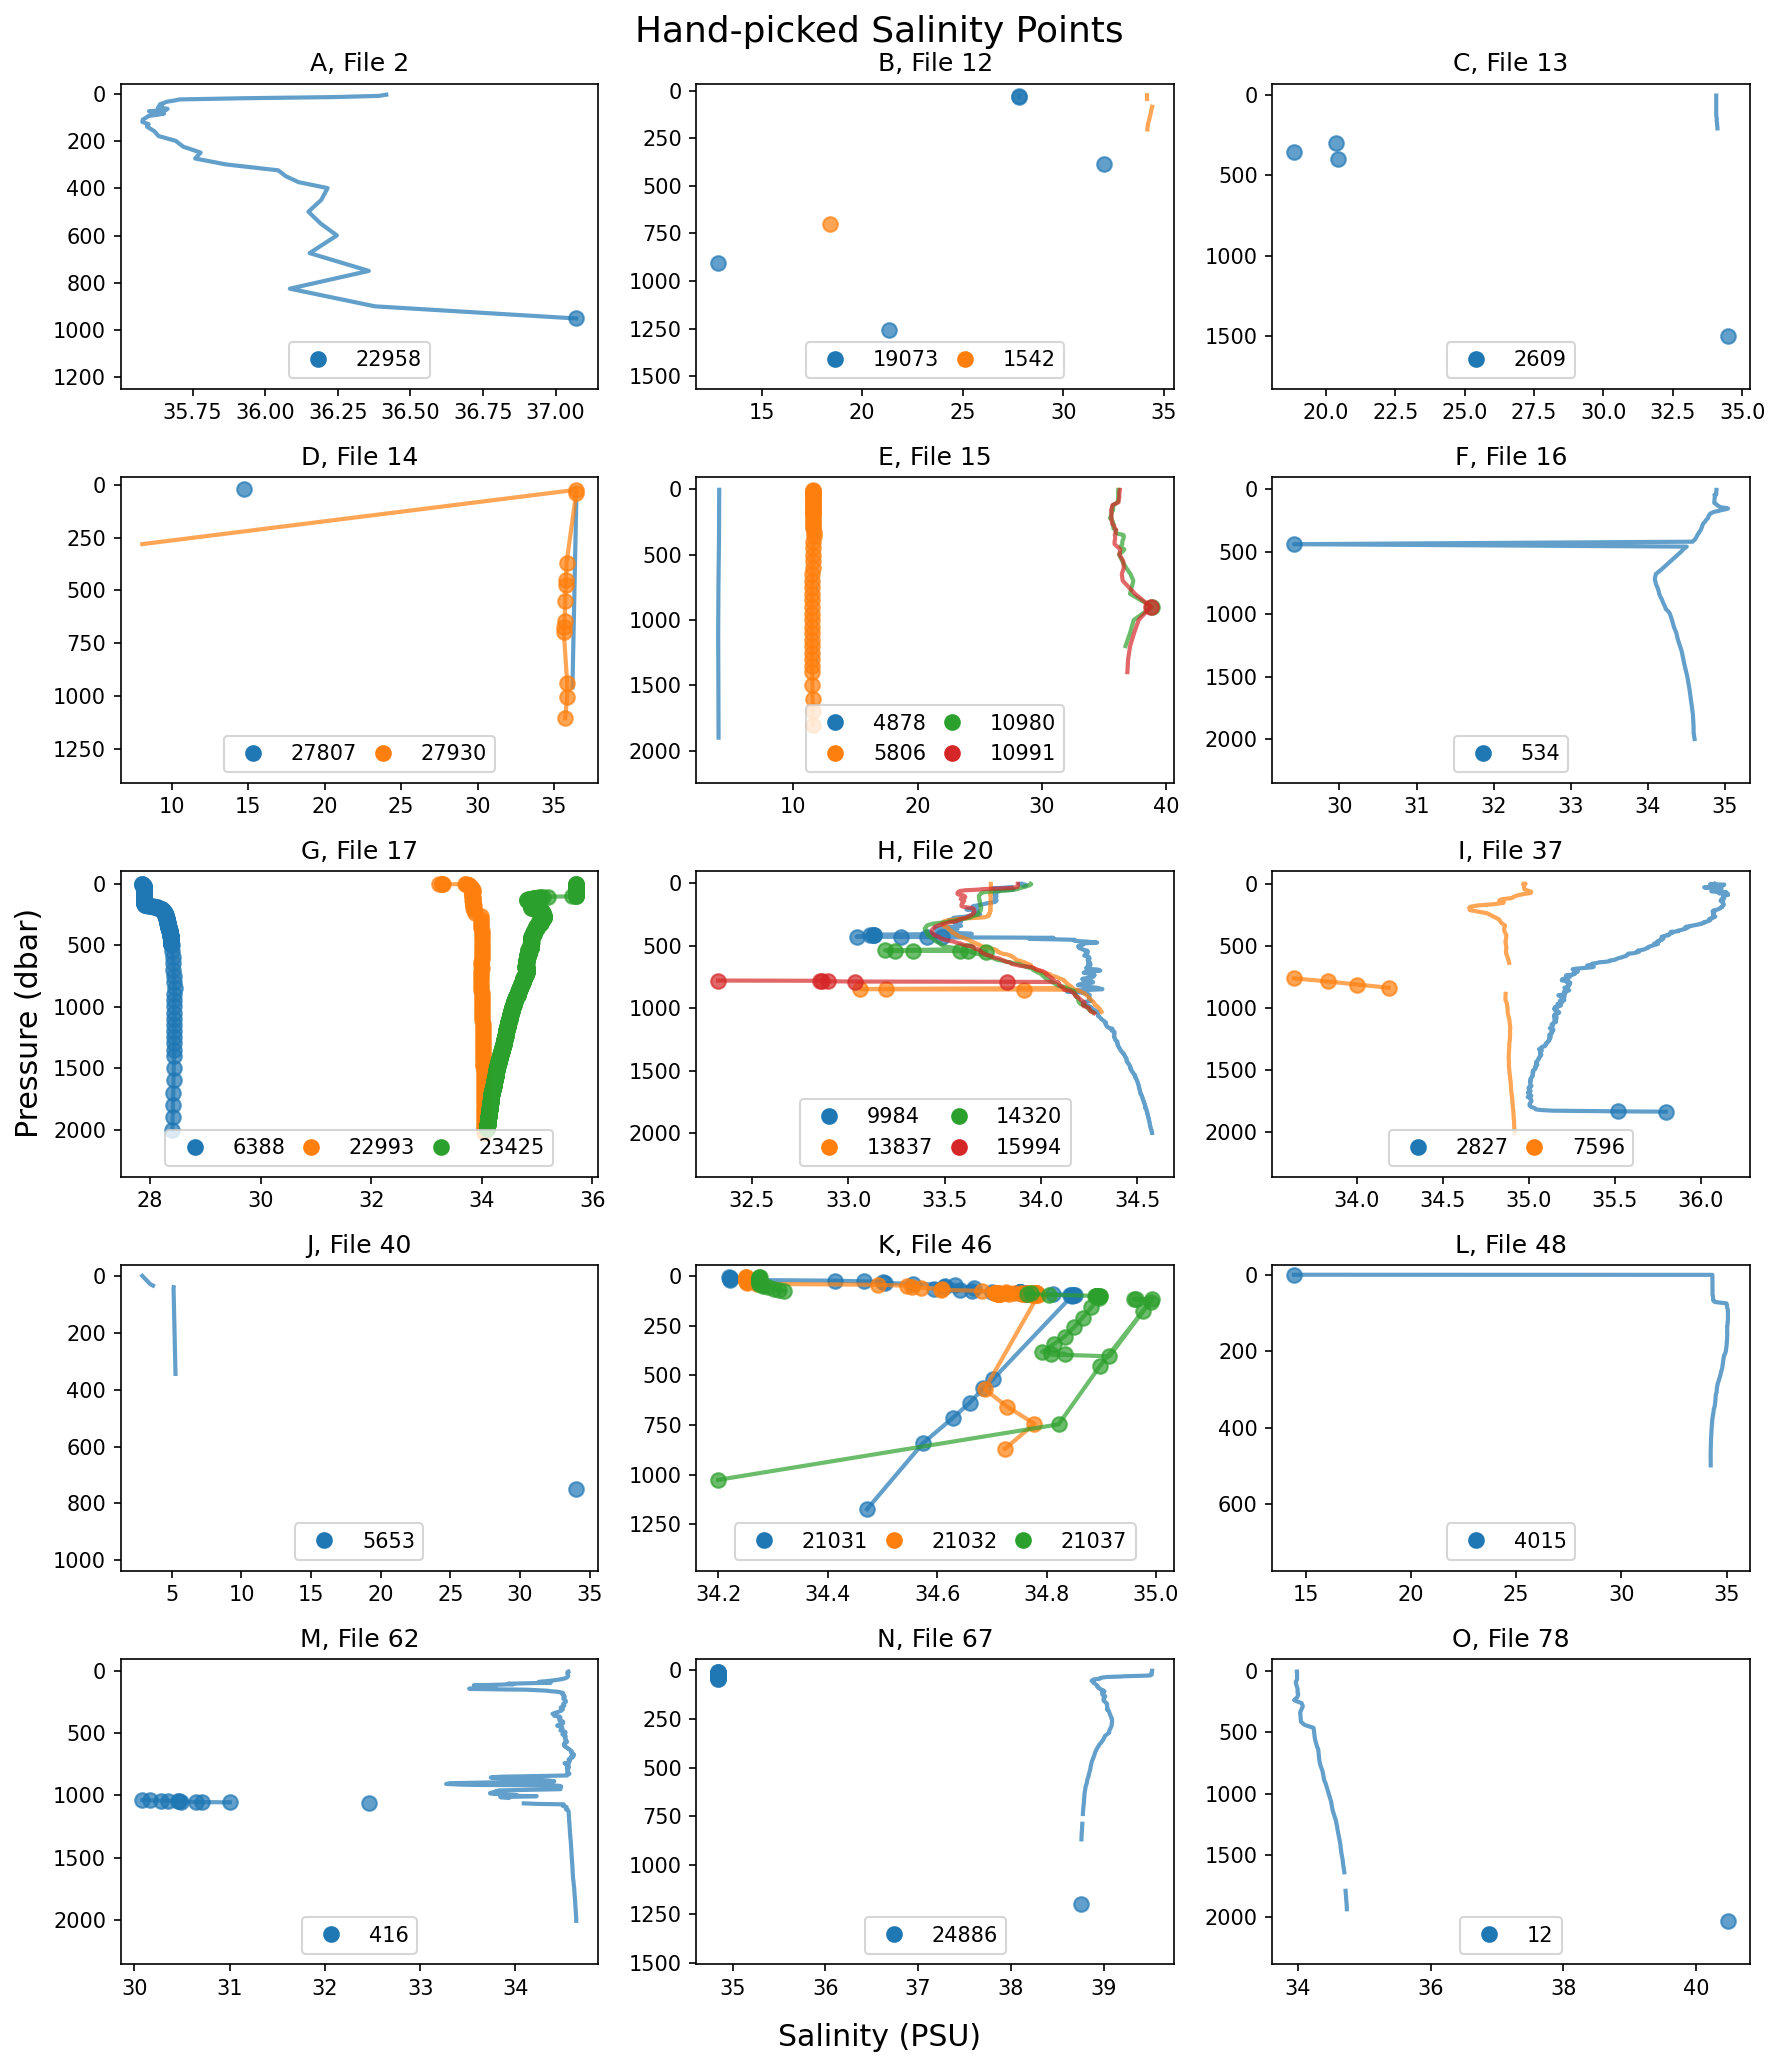

In [49]:
# Plot hand-picked points salinity individually
fig,ax = plt.subplots(5,3, figsize=(12,14)) 
fig_fp = join(figures_dir, 'hp_pnts_figs/hp_PSAL.pdf')

# make an array of indices to iterate through the axes which is 5x3
axes_inds = np.array([(i,j) for i in range(5) for j in range(3)])

# generate array of letters to use for subplot titles
letters = np.array(list(string.ascii_uppercase)[:num_files])	

for file_i, filenum in enumerate(filenums):
	nc = join( data_dir, 'global_profiles.{:02d}.nc'.format(filenum) )
	data = xr.open_dataset(nc)
	i=0
	row,col = axes_inds[file_i]

	plotted_cycs = []
	for (sample_i,cyc_i) in hp_PSAL[filenum]:
		PSAL = data.PSAL.isel(cycle=cyc_i)
	# 	if np.any(PSAL < 10):
	# 		# Make PSAL points under 10 to be NaN so they don't plot
	# 		arr = PSAL.values
	# 		arr[arr < 10] = np.nan 
	# 		data.PSAL.loc[dict(cycle=cyc_i)] = arr

		if not cyc_i in plotted_cycs:
			plotted_cycs.append(cyc_i)
			prof = ax[row,col].plot(data['PSAL'].isel(cycle=cyc_i),
						data['PRES'].isel(cycle=cyc_i),
						'-',
						lw=2,
						label=str(cyc_i), 
						# color=cyc_colors[i]
						alpha=0.7,
						)
			curr_cyc_color = prof[0].get_color()
			i+=1
		point = ax[row,col].plot(data['PSAL'].isel(cycle=cyc_i).isel(sample=sample_i),
				data['PRES'].isel(cycle=cyc_i).isel(sample=sample_i),
				'o', 
				# markeredgecolor='k',
				# markeredgewidth=0.5,
				# label=str(cyc_i), 
				c=curr_cyc_color, 
				alpha=0.7,
				markersize=7)
		
	ax[row,col].set_title(letters[file_i] + ', File '+ str(filenum), fontsize='large')

	# Add a little bit of vertical space to the bottom of the plot to have room for legend
	# print(ax[row,col].get_ylim())
	ax[row,col].set_ylim([ax[row,col].get_ylim()[0],ax[row,col].get_ylim()[1] + 250])
	ax[row,col].invert_yaxis()
	cols = 0
	if i == 1: cols = 1
	if i == 2 or i == 4: cols = 2
	if i == 3: cols = 3

	ax[row,col].legend(loc='lower center', 
				ncols=cols,
				# nrows=2,
				columnspacing=0.25,
				# title='Cycle index', 
			#   title_fontsize='large', fontsize='large'
				)
				
	# change legend elements to circles instead of lines
	leg = ax[row,col].get_legend()
	for lh in leg.legend_handles: 
		lh.set_alpha(1)
		lh.set_linestyle('')
		lh.set_marker('o')
		lh.set_markersize(7)

	print(filenum, 'plotted')

fig.supxlabel('Salinity (PSU)', fontsize='x-large')
fig.supylabel('Pressure (dbar)', fontsize='x-large')
fig.suptitle("Hand-picked Salinity Points", fontsize='xx-large')

plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(fig_fp, dpi=300)
plt.show()

3
16 plotted
17 plotted
32 plotted


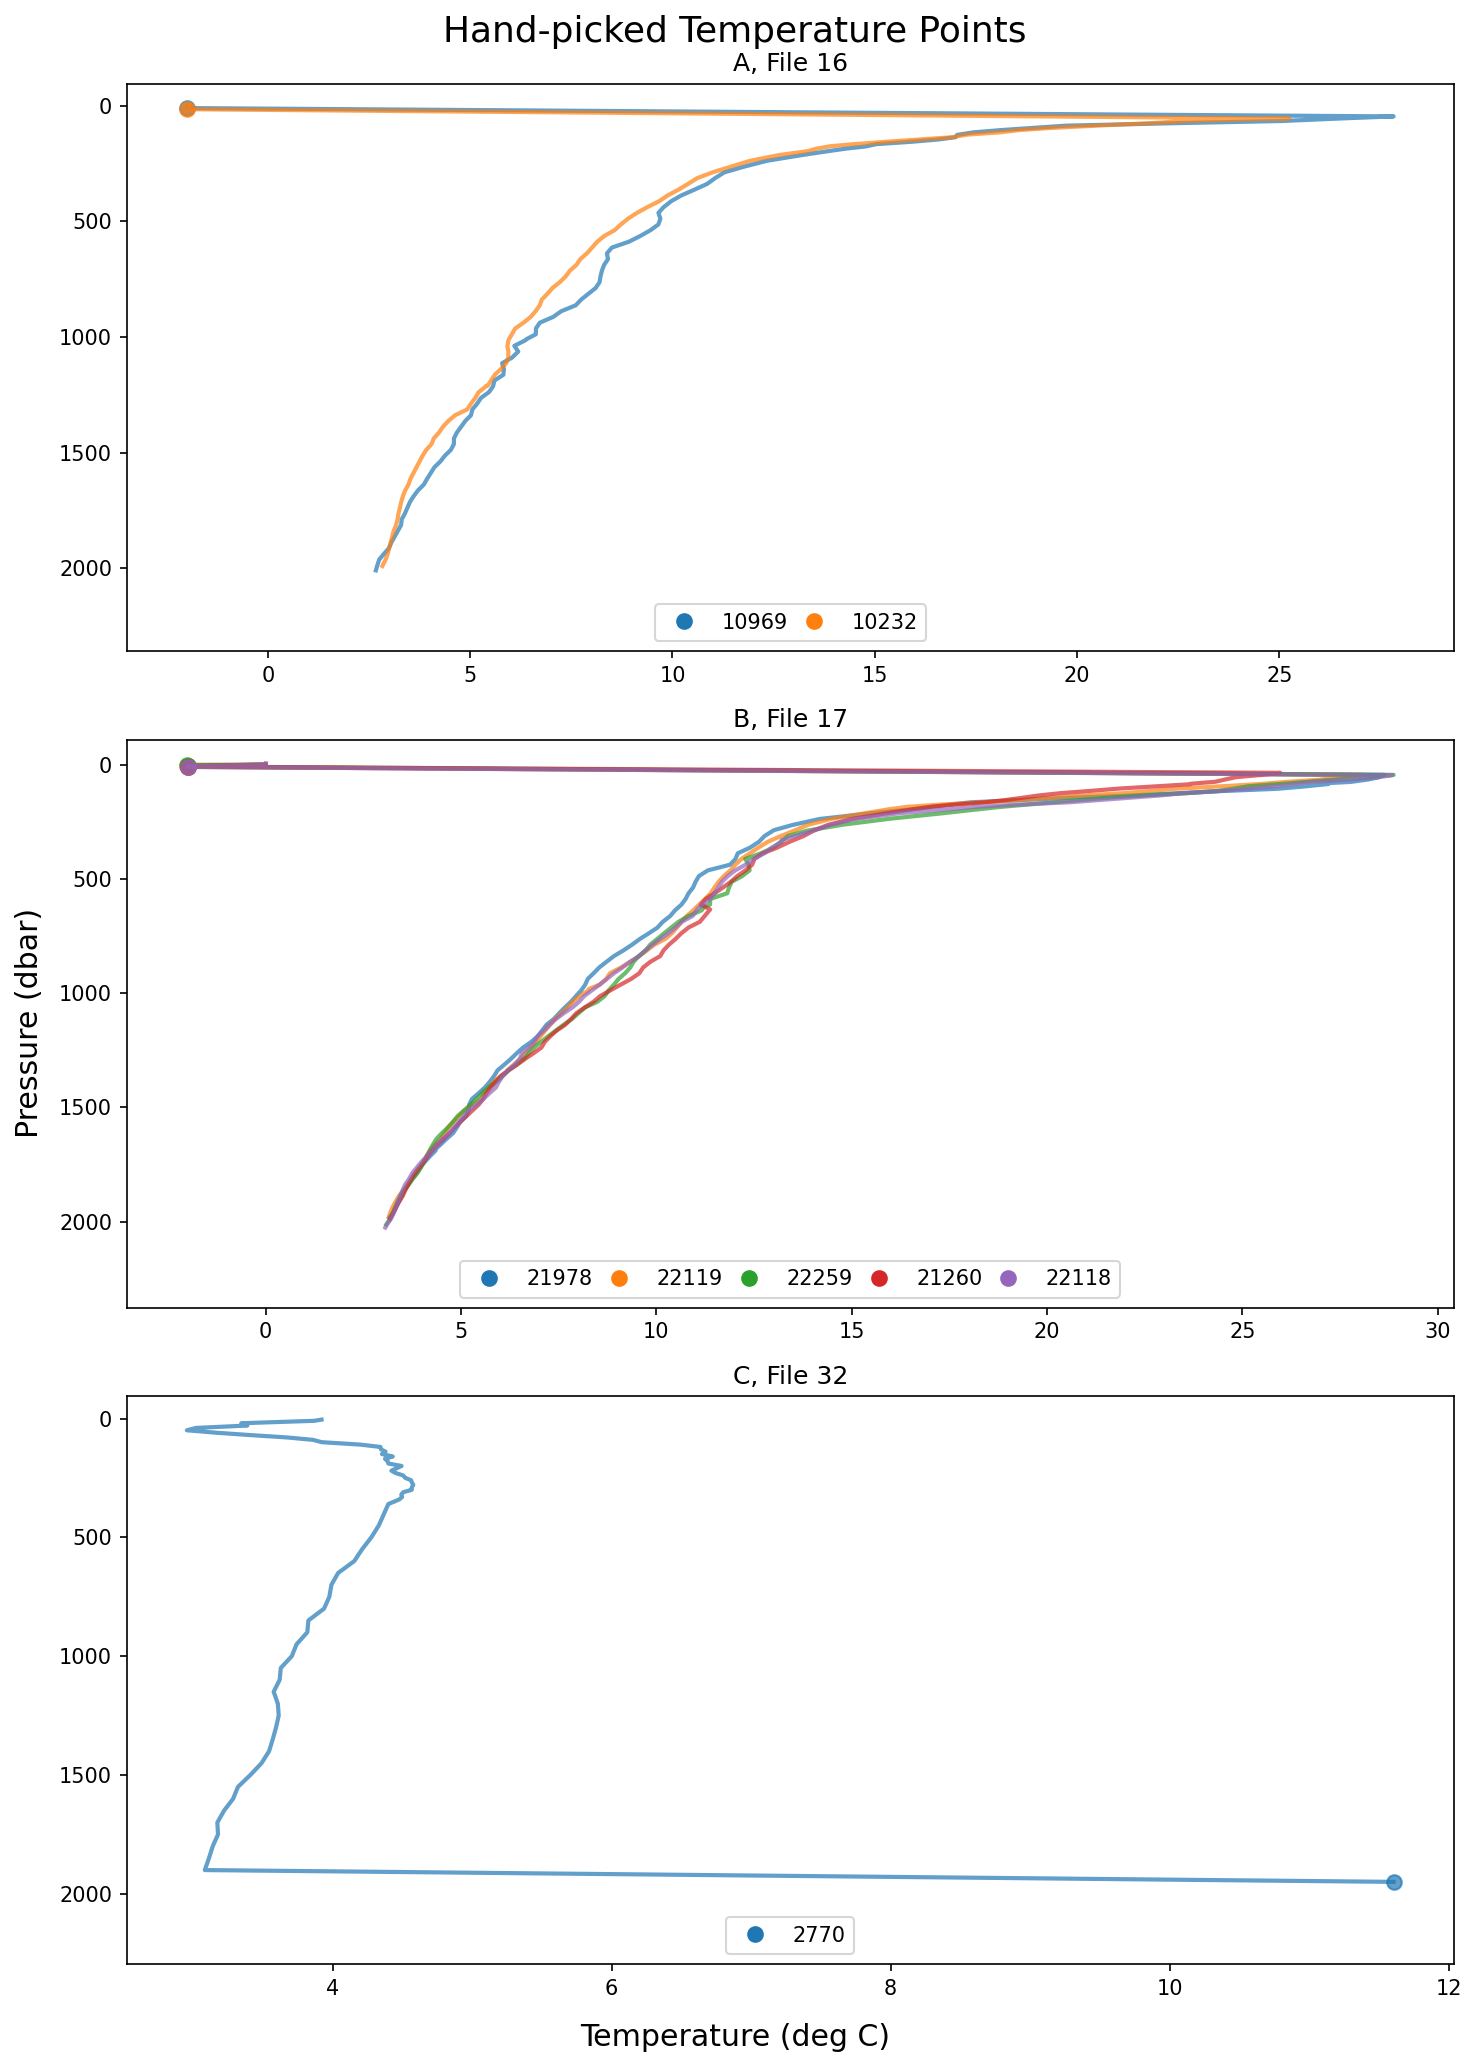

In [42]:
# Plot hand-picked temperature individually

fig,ax = plt.subplots(3,1, figsize=(10,14)) 
fig_fp = join(figures_dir, 'hp_pnts_figs/hp_TEMP.pdf')

# make an array of indices to iterate through the axes which is 3x1
axes_inds = np.array([i for i in range(3)])

# generate array of letters to use for subplot titles
letters = np.array(list(string.ascii_uppercase)[:num_files])	

for file_i, filenum in enumerate(filenums):
	nc = join( data_dir, 'global_profiles.{:02d}.nc'.format(filenum) )
	data = xr.open_dataset(nc)
	i=0
	row = axes_inds[file_i]

	plotted_cycs = []
	for (sample_i,cyc_i) in hp_TEMP[filenum]:
		TEMP = data.TEMP.isel(cycle=cyc_i)

		if not cyc_i in plotted_cycs:
			plotted_cycs.append(cyc_i)
			prof = ax[row].plot(data['TEMP'].isel(cycle=cyc_i),
						data['PRES'].isel(cycle=cyc_i),
						'-',
						lw=2,
						label=str(cyc_i), 
						# color=cyc_colors[i]
						alpha=0.7,
						)
			curr_cyc_color = prof[0].get_color()
			i+=1
		point = ax[row].plot(data['TEMP'].isel(cycle=cyc_i).isel(sample=sample_i),
				data['PRES'].isel(cycle=cyc_i).isel(sample=sample_i),
				'o', 
				# markeredgecolor='k',
				# markeredgewidth=0.5,
				# label=str(cyc_i), 
				c=curr_cyc_color, 
				alpha=0.7,
				markersize=7)
		
	ax[row].set_title(letters[file_i] + ', File '+ str(filenum), fontsize='large')

	# Add a little bit of vertical space to the bottom of the plot to have room for legend
	ax[row].set_ylim([ax[row].get_ylim()[0],
				   ax[row].get_ylim()[1] + 250])
	ax[row].invert_yaxis()
	cols = 0
	if i == 1: cols = 1
	if i == 2 or i == 4: cols = 2
	if i == 3: cols = 3
	if i == 5: cols = 5

	ax[row].legend(
				loc='lower center', 
				ncols=cols,
				# nrows=2,
				columnspacing=0.25,
				# title='Cycle index', 
			#   title_fontsize='large', fontsize='large'
				)
				
	# change legend elements to circles instead of lines
	leg = ax[row].get_legend()
	for lh in leg.legend_handles: 
		lh.set_alpha(1)
		lh.set_linestyle('')
		lh.set_marker('o')
		lh.set_markersize(7)

	print(filenum, 'plotted')

fig.supxlabel('Temperature (deg C)', fontsize='x-large')
fig.supylabel('Pressure (dbar)', fontsize='x-large')
fig.suptitle("Hand-picked Temperature Points", fontsize='xx-large')

plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(fig_fp, dpi=300)
plt.show()

### Statistics + Analysis of data QC

In [10]:
# Dictionaries of flags and their descriptions
prof_flags_descrip = {'0':'Good Data',
				   '1':'Repeated or out \nof order pressure', 
				   '2':'Salinity gradient', 
				   '3':'Both flag 1 and 2', 
					'4':'4 or fewer measurements', 
					'5':'Out of bounds time range \nor no time data' ,
				   '6':'No geo-coordinates'}

pnt_flags_descrip = {'0':'Good Data',
				   '1':'Missing or OOR PRES',
				   '2':'Missing or OOR TEMP',
				   '3':'Missing or OOR PSAL',
				   '4':'Bad TEMP points \nhand picked',
				   '5':'Bad PSAL points \nhand picked'}

special_areas_descrip = {'0':'Non-special' ,
                        '1':'Mediterranean Sea',
                        '2':'Baltic Sea',
                        '3':'Indian Ocean flow-through; \ncoastal West Pacific Ocean',
                        '4':'Gulf of Mexico; \nCaribbean Sea',
                        '5':'Coastal Pakistan'}

\begin{longtable}{llllllll}
\hline
 Filenum   & Flag 0 \%   & Flag 1 \%   & Flag 2 \%   & Flag 3 \%   & Flag 4 \%   & Flag 5 \%   & Flag 6 \%   \\
\hline
\endhead
 1         & 70.64      & 0          & 0.01       & 0          & 27.07      & 0          & 2.28       \\
 2         & 71.96      & 0.05       & 0.2        & 0          & 27.56      & 0          & 0.24       \\
 3         & 65.89      & 0          & 0.59       & 0          & 33.42      & 0          & 0.1        \\
 4         & 92.51      & 0.03       & 0.01       & 0          & 7.34       & 0          & 0.11       \\
 5         & 95.14      & 1.07       & 0.07       & 0          & 2.93       & 0          & 0.8        \\
 6         & 96.31      & 0          & 0.03       & 0          & 2.47       & 0.25       & 0.94       \\
 7         & 97.25      & 0          & 0          & 0          & 1.88       & 0.22       & 0.65       \\
 8         & 89.45      & 0          & 0          & 0          & 2.36       & 7.63       & 0.56       

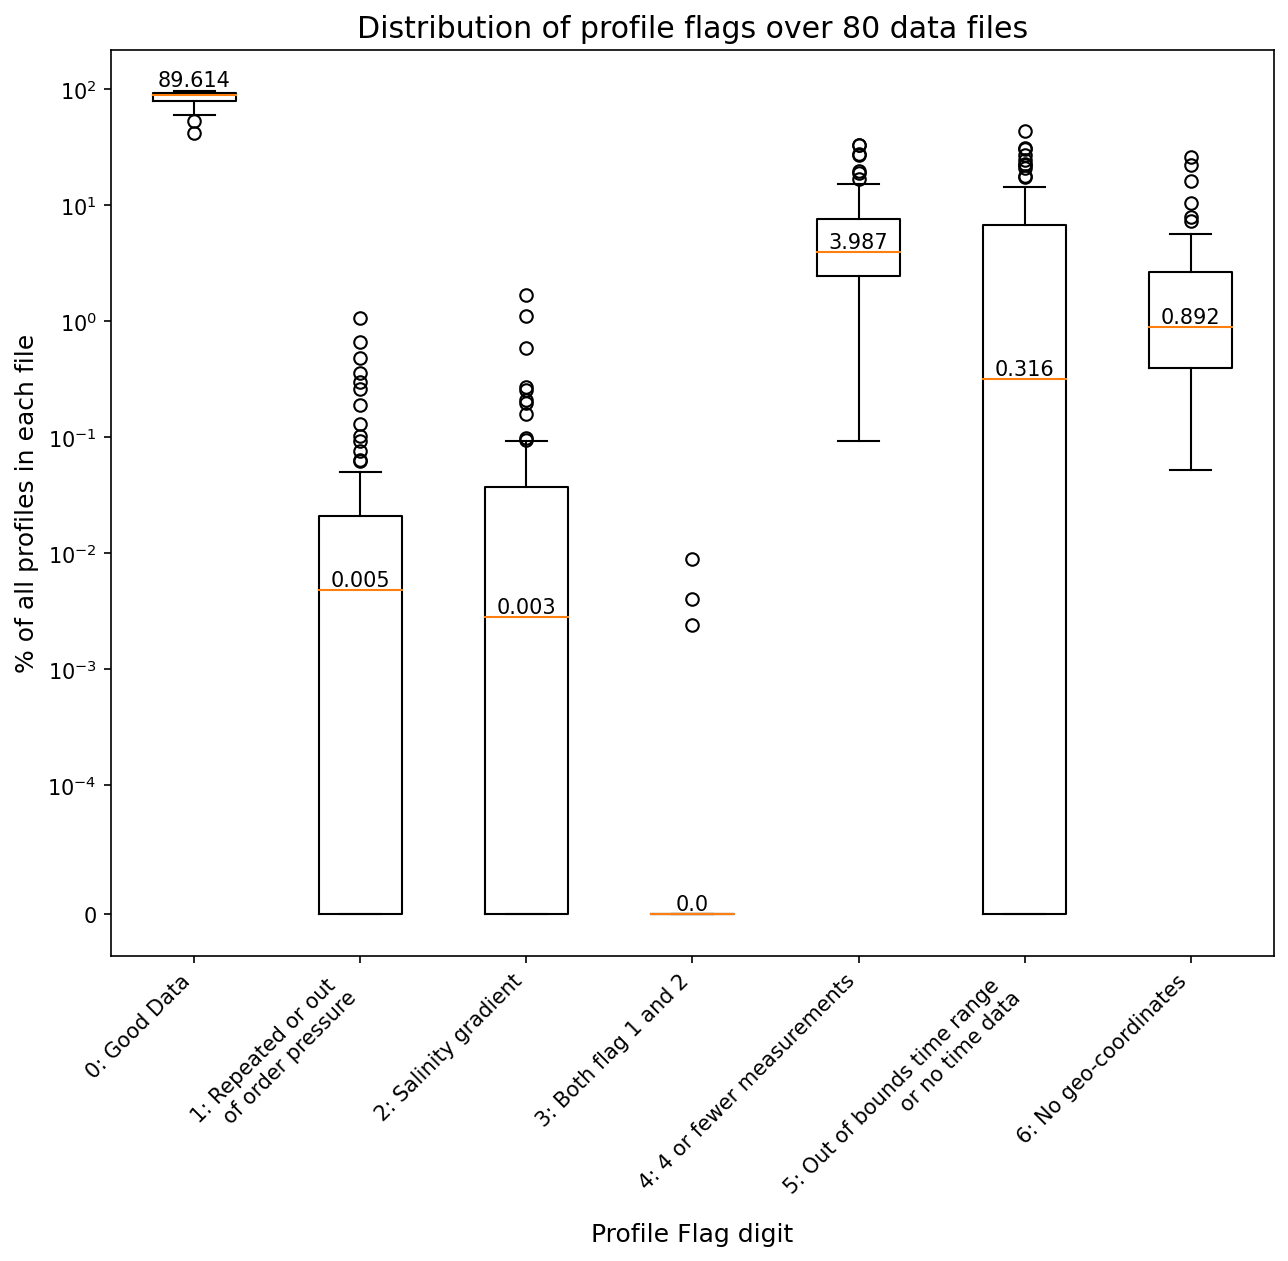

In [13]:
# Create profile bxp and freq/count table stats
flag_labels = np.arange(0,7)
freq_arr = np.zeros((maxnum,len(flag_labels)))
count_arr = np.zeros((maxnum,len(flag_labels)))

for filenum in range(1,maxnum+1):
	flag_array_nc = join( flag_array_dir, 'flag_arrays.{:02d}.nc'.format(filenum) )
	flag_arrays = xr.open_dataset(flag_array_nc)
	prof_flags = flag_arrays['bad_prof']

	for flag_digit in flag_labels:
		count = np.sum(prof_flags == flag_digit)
		count_arr[filenum-1,flag_digit] = count
		digit_freq = count/len(prof_flags)*100
		freq_arr[filenum-1,flag_digit] = digit_freq
	
bxp_stats = cbook.boxplot_stats(freq_arr, labels=flag_labels.astype(str))

fig,ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')
ax.bxp(bxp_stats)
ax.set_yscale('symlog',linthresh=1e-4) # min non-zero val in freq_arr is 2e-3
ax.set_title('Distribution of profile flags over 80 data files', fontsize='x-large')
ax.set_xlabel('Profile Flag digit', fontsize='large')
ax.set_ylabel(f'% of all profiles in each file', fontsize='large')

# Set tick labels according to prof_flags dictionary
tick_labels = [str(label)+': '+prof_flags_descrip[str(label)] for label in flag_labels]
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

for i in range(len(bxp_stats)):
	if i == 0:
		ax.annotate(round(bxp_stats[i]['med'],3), (i+1, bxp_stats[i]['med']+10), ha='center', fontsize=10, va='bottom')
	else: ax.annotate(round(bxp_stats[i]['med'],3), (i+1, bxp_stats[i]['med']), ha='center', fontsize=10, va='bottom')

plt.savefig(join( figures_dir, 'prof_flag_bxp.pdf' ), bbox_inches='tight', dpi=300) 

# Frequencies table
freq_arr = np.hstack((np.array([np.arange(1,maxnum+1)]).T,np.around(freq_arr,2)))
table = tabulate(freq_arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','Flag 0 %','Flag 1 %','Flag 2 %','Flag 3 %','Flag 4 %','Flag 5 %','Flag 6 %']) 
print(table)

# Counts table
count_arr = np.around(count_arr,3)
arr = np.hstack((count_arr,np.array([np.sum(count_arr, axis=1)]).T))
arr = np.vstack((arr,np.array([np.sum(arr,axis=0)])))
first_col = np.append(np.array([np.arange(1,maxnum+1)]),'Total')
first_col = np.reshape(first_col, (first_col.size,1))
arr = np.hstack((first_col,arr))
table = tabulate(arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','Flag 0','Flag 1','Flag 2','Flag 3','Flag 4','Flag 5','Flag 6','Total']) 
print(table)

print( arr [-1,:])


\begin{longtable}{lllllll}
\hline
 Filenum   & Flag 0 \%   & Flag 1 \%   & Flag 2 \%   & Flag 3 \%   & Flag 4 \%   & Flag 5 \%   \\
\hline
\endhead
 1         & 99.7       & 0          & 0          & 0.04       & 0.26       & 0          \\
 2         & 100        & 0          & 0          & 0          & 0          & 0          \\
 3         & 94.4       & 5.6        & 0          & 0          & 0          & 0          \\
 4         & 93.28      & 6.72       & 0          & 0          & 0          & 0          \\
 5         & 99.23      & 0.77       & 0          & 0          & 0          & 0          \\
 6         & 100        & 0          & 0          & 0          & 0          & 0          \\
 7         & 98.72      & 0.99       & 0          & 0          & 0.29       & 0          \\
 8         & 100        & 0          & 0          & 0          & 0          & 0          \\
 9         & 100        & 0          & 0          & 0          & 0          & 0          \\
 10        & 92.94      

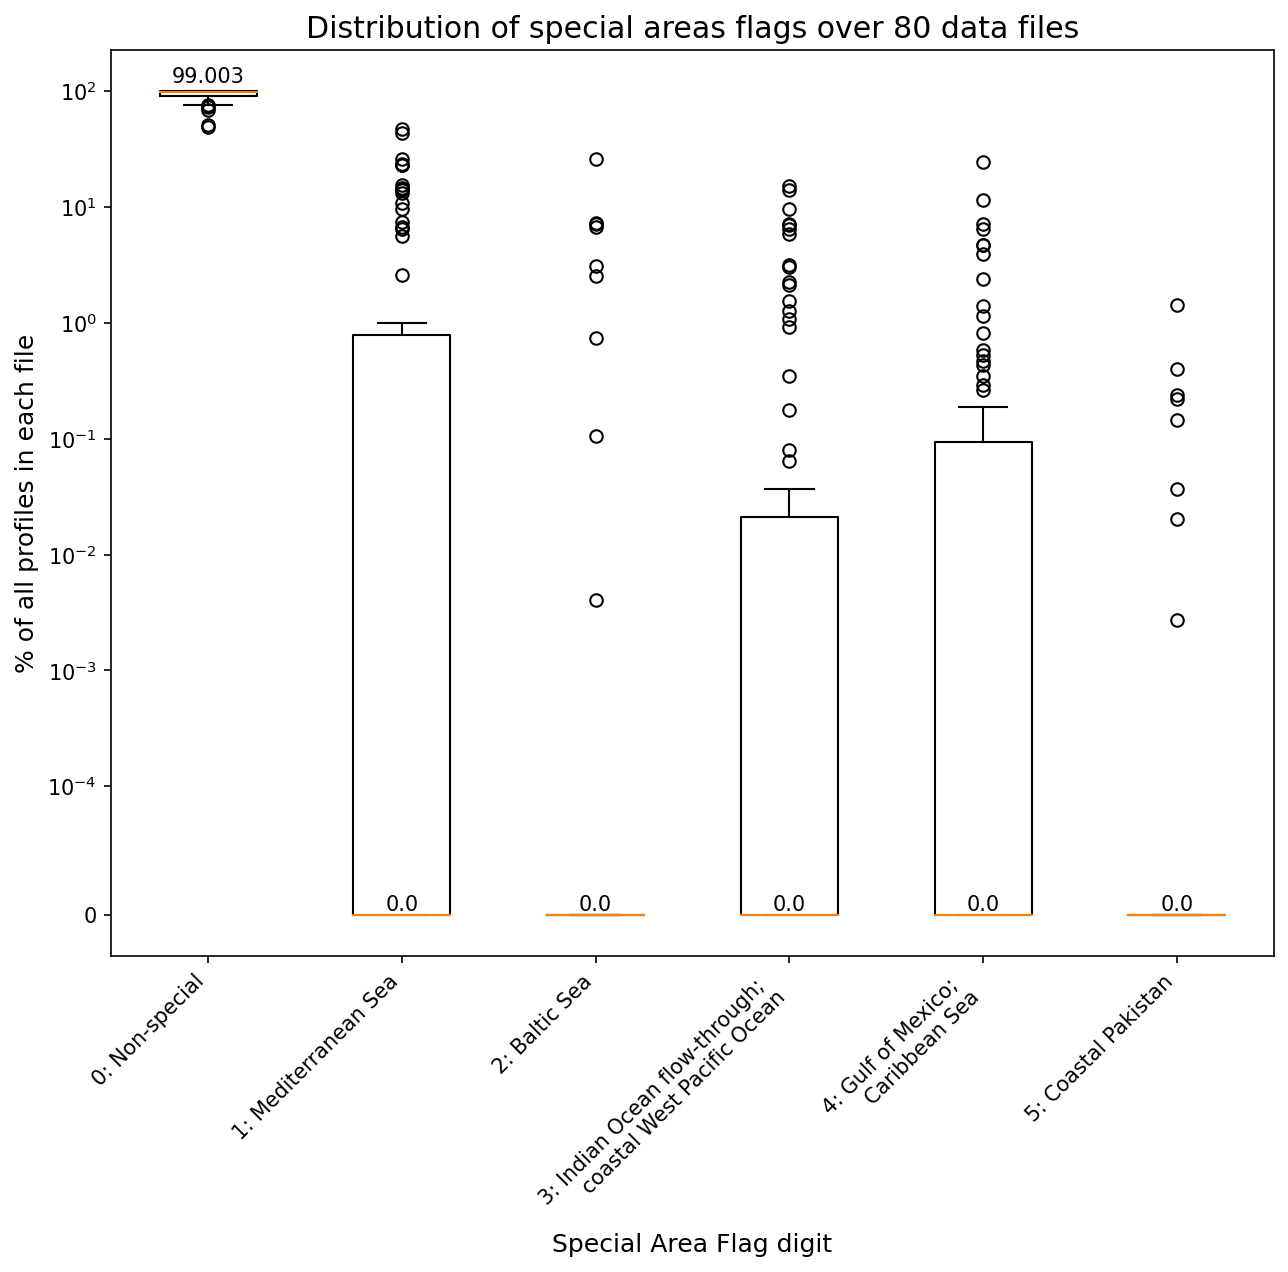

In [15]:
# Create special areas bxp and freq/count table stats
flag_labels = np.arange(0,6)
freq_arr = np.zeros((maxnum,len(flag_labels)))
count_arr = np.zeros((maxnum,len(flag_labels)))

for filenum in range(1,maxnum+1):
	flag_array_nc = join( flag_array_dir, 'flag_arrays.{:02d}.nc'.format(filenum) )
	flag_arrays = xr.open_dataset(flag_array_nc)
	prof_flags = flag_arrays['special_areas']
	for flag_digit in flag_labels:
		count = np.sum(prof_flags == flag_digit)
		count_arr[filenum-1,flag_digit] = count
		digit_freq = count/len(prof_flags)*100
		freq_arr[filenum-1,flag_digit] = digit_freq
bxp_stats = cbook.boxplot_stats(freq_arr, labels=flag_labels.astype(str))

fig,ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')
ax.bxp(bxp_stats)
ax.set_yscale('symlog',linthresh=1e-4) # min non-zero val in freq_arr is 2e-3
ax.set_title('Distribution of special areas flags over 80 data files', fontsize='x-large')
ax.set_xlabel('Special Area Flag digit', fontsize='large')
ax.set_ylabel('% of all profiles in each file', fontsize='large')

# Set tick labels according to prof_flags dictionary
tick_labels = [str(label)+': '+special_areas_descrip[str(label)] for label in flag_labels]
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

for i in range(len(bxp_stats)):
	if i == 0:
		ax.annotate(round(bxp_stats[i]['med'],3), (i+1, bxp_stats[i]['med']+10), ha='center', fontsize=10, va='bottom')
	else: ax.annotate(round(bxp_stats[i]['med'],3), (i+1, bxp_stats[i]['med']), ha='center', fontsize=10, va='bottom')

plt.savefig( join(figures_dir, 'special_areas_flag_bxp.pdf'), bbox_inches='tight', dpi=300)

# Frequencies table
freq_arr = np.hstack((np.array([np.arange(1,maxnum+1)]).T,np.around(freq_arr,2)))
table = tabulate(freq_arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','Flag 0 %','Flag 1 %','Flag 2 %','Flag 3 %','Flag 4 %','Flag 5 %']) 
print(table)

# Counts table
count_arr = np.around(count_arr,3)
arr = np.hstack((count_arr,np.array([np.sum(count_arr, axis=1)]).T))
arr = np.vstack((arr,np.array([np.sum(arr,axis=0)])))
first_col = np.append(np.array([np.arange(1,maxnum+1)]),'Total')
first_col = np.reshape(first_col, (first_col.size,1))
arr = np.hstack((first_col,arr))
table = tabulate(arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','Flag 0','Flag 1','Flag 2','Flag 3','Flag 4','Flag 5','Total']) 
print(table)


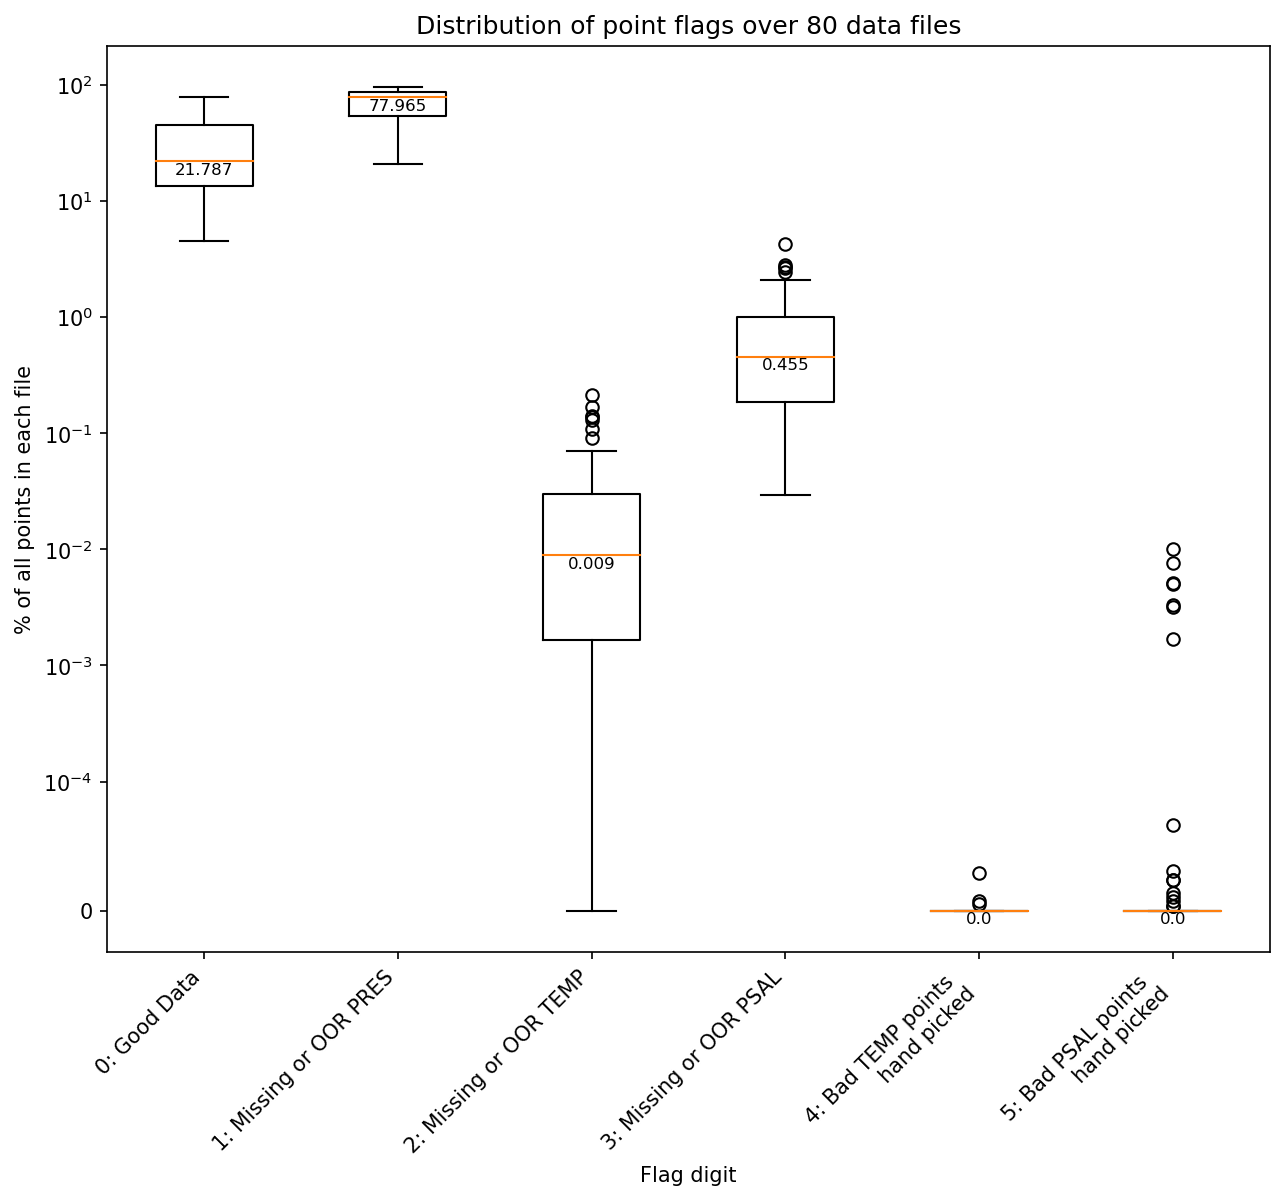

In [32]:
# Create pnt bxp and freq/count table stats
flag_labels = np.arange(0,len(pnt_flags_descrip.keys()))
freq_arr = np.zeros((maxnum,len(flag_labels)))
count_arr = np.zeros((maxnum,len(flag_labels)))

for filenum in range(1,maxnum+1):
	flag_array_nc = join(flag_array_dir, 'flag_arrays.{:02d}.nc'.format(filenum))
	flag_arrays = xr.open_dataset(flag_array_nc)
	pnt_flags = flag_arrays['bad_pnts']
	for flag_digit in flag_labels:
		count = np.sum(pnt_flags == flag_digit)
		count_arr[filenum-1,flag_digit] = count
		digit_freq = (count/pnt_flags.size)*100
		freq_arr[filenum-1,flag_digit] = digit_freq
bxp_stats = cbook.boxplot_stats(freq_arr, labels=flag_labels.astype(str))

fig,ax = plt.subplots(figsize=(10,8))
ax.bxp(bxp_stats) # ,medianprops={'alpha':0.7,'marker':'_'}
ax.set_yscale('symlog',linthresh=1e-4)
ax.set_title('Distribution of point flags over 80 data files')
ax.set_xlabel('Flag digit')
ax.set_ylabel('% of all points in each file')

# Set tick labels according to prof_flags dictionary
tick_labels = [str(label)+': '+pnt_flags_descrip[str(label)] for label in flag_labels]
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

for i in range(len(bxp_stats)):	
	ax.annotate(round(bxp_stats[i]['med'],3), (i+1, bxp_stats[i]['med']), 
			ha='center', fontsize=8, va='top', 
			xytext=(0, -0.5), textcoords='offset points')

plt.savefig(join(figures_dir, 'pnts_flag_bxp.pdf'), bbox_inches='tight', dpi=300)
# plt.show()

# Frequencies table
freq_arr = np.around(freq_arr,3)
first_col = np.array([np.arange(1,maxnum+1)])
first_col = np.reshape(first_col, (first_col.size,1))
arr = np.hstack((first_col,freq_arr))
table = tabulate(arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','Flag 0 %','Flag 1 %','Flag 2 %','Flag 3 %','Flag 4 %',
				 'Flag 5 %']) 
print(table)

# Counts table
count_arr = np.around(count_arr,3)
arr = np.hstack((count_arr,np.array([np.sum(count_arr, axis=1)]).T))
arr = np.vstack((arr,np.array([np.sum(arr,axis=0)])))
first_col = np.append(np.array([np.arange(1,maxnum+1)]),'Total')
first_col = np.reshape(first_col, (first_col.size,1))
arr = np.hstack((first_col,arr))
table = tabulate(arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','Flag 0','Flag 1','Flag 2','Flag 3','Flag 4','Flag 5','Total']) 
print(table)

In [43]:
# Data mode stats
mode_labels = [b'R',b'A',b'D']
freq_arr = np.zeros((maxnum,len(mode_labels)))
count_arr = np.zeros((maxnum,len(mode_labels)))
total_prof = np.zeros((maxnum,1))

for filenum in range(1,maxnum+1):
	data_nc = join( data_dir, 'global_profiles.{:02d}.nc'.format(filenum)) 
	data = xr.open_dataset(data_nc)
	mode_data = data['DATA_MODE']
	total_prof[filenum-1] = len(mode_data)
	for i,mode in enumerate(mode_labels):
		count = np.sum(mode_data==mode)
		count_arr[filenum-1,i] = count
		digit_freq = count/len(mode_data)*100
		freq_arr[filenum-1,i] = digit_freq

freq_arr = np.around(freq_arr,3)
num_profs = np.sum(total_prof)
total_row = np.sum(count_arr,axis=0)
total_row = total_row/num_profs*100
arr = np.vstack((freq_arr,np.array([total_row])))
first_col = np.append(np.array([np.arange(1,maxnum+1)]),'Total %')
first_col = np.reshape(first_col, (first_col.size,1))
arr = np.hstack((first_col,arr))
table = tabulate(arr,numalign="left", tablefmt="latex_longtable",
		headers=['Filenum','% R','% A','% D']) 
print(table)

\begin{longtable}{llll}
\hline
 Filenum   & \% R     & \% A     & \% D     \\
\hline
\endhead
 1         & 0.005   & 0.005   & 99.989  \\
 2         & 0.404   & 6.125   & 93.471  \\
 3         & 0.049   & 0.213   & 99.738  \\
 4         & 1.035   & 1.894   & 97.071  \\
 5         & 0.055   & 2.267   & 97.678  \\
 6         & 0.094   & 4.741   & 95.165  \\
 7         & 0.755   & 1.355   & 97.89   \\
 8         & 5.632   & 17.721  & 76.647  \\
 9         & 23.918  & 15.681  & 60.401  \\
 10        & 5.611   & 3.415   & 90.974  \\
 11        & 0.011   & 20.065  & 79.924  \\
 12        & 0.061   & 9.289   & 90.65   \\
 13        & 9.807   & 26.289  & 63.905  \\
 14        & 0.417   & 37.541  & 62.042  \\
 15        & 1.161   & 52.869  & 45.97   \\
 16        & 15.864  & 4.02    & 80.116  \\
 17        & 26.711  & 60.015  & 13.275  \\
 18        & 0       & 33.789  & 66.211  \\
 19        & 8.626   & 11.683  & 79.69   \\
 20        & 2.123   & 34.25   & 63.627  \\
 21        & 23.709  & 36.

In [44]:
# Print general data stats: the total number of cycles, earliest time, latest time, maximum longitude, minimum longitude, 
# maximum latitude, minimum latitude, number of unique FLOATNUMs
#  in all the RAWdata files global_profile_*.nc
min_time = 0
num_cycs = 0
max_time = 0
max_lon = -999
min_lon = 999
max_lat = -999
min_lat = 999
num_floats = 0
maxnum=80

for filenum in range(1,maxnum+1):
    data_nc = join(data_dir,'global_profiles.{:02d}.nc'.format(filenum) )
    data = xr.open_dataset(data_nc)
    datetimes = data['DATENUM'].values
    LON = data['LON'].values
    LAT = data['LAT'].values
    FLOATNUM = data['FLOATNUM'].values

    num_cycs += len(data['cycle'])
    num_floats += len(np.unique(FLOATNUM))

    if min_time == 0:
        min_time = np.min(datetimes)
    else:
        curr_min = np.min(datetimes)
        if curr_min < min_time:
            min_time = curr_min
    
    if max_time == 0:
        max_time = np.max(datetimes)
    else:
        curr_max = np.max(datetimes)
        if curr_max > max_time:
            max_time = curr_max
    
    if max_lon == 0:
        max_lon = np.max(LON)
    else:
        curr_max = np.max(LON)
        if curr_max > max_lon:
            max_lon = curr_max
    
    if min_lon == 0:
        min_lon = np.min(LON)
    else:
        curr_min = np.min(LON)
        if curr_min < min_lon:
            min_lon = curr_min
    
    if max_lat == 0:
        max_lat = np.max(LAT)
    else:
        curr_max = np.max(LAT)
        if curr_max > max_lat:
            max_lat = curr_max
    
    if min_lat == 0:
        min_lat = np.min(LAT)
    else:
        curr_min = np.min(LAT)
        if curr_min < min_lat:
            min_lat = curr_min
    
print('Total number of cycles: ', num_cycs)
# Convert from matlab datenum to python datetime
import pandas as pd
max_time = pd.to_datetime(max_time-719529, unit='D')
min_time = pd.to_datetime(min_time-719529, unit='D')
print('Earliest time: ', min_time)
print('Latest time: ', max_time)
print('Maximum longitude: ', max_lon)
print('Minimum longitude: ', min_lon)
print('Maximum latitude: ', max_lat)
print('Minimum latitude: ', min_lat)
print('Number of unique floats: ', num_floats)

Total number of cycles:  2383458
Earliest time:  2004-01-01 00:18:12.999985792
Latest time:  2022-08-11 08:59:45.000000768
Maximum longitude:  179.998
Minimum longitude:  -179.998
Maximum latitude:  76.219
Minimum latitude:  -66.747
Number of unique floats:  15850


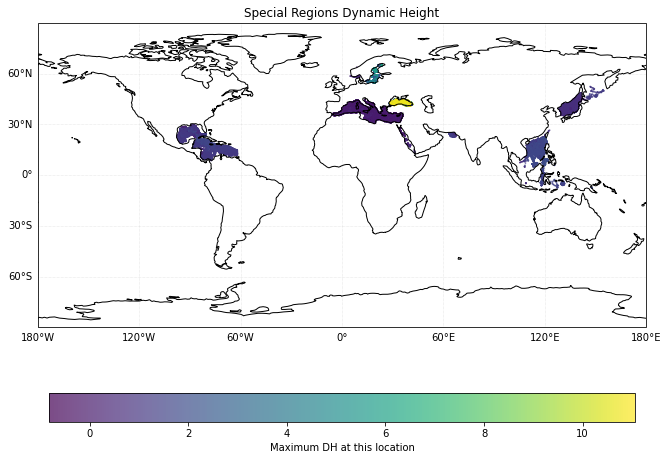

In [18]:
# Plot dynamic height distribution map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mask_polygons_utils import polygons_from_txt, load_polygons, to_mask
polygons = load_polygons(join( main_dir, 'special_areas_polygons.shp'))

## Define range to plot
title = r'Special Regions Dynamic Height'
imgName = 'polygons_dh'

## Cartopy plotting
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15,8))
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                    draw_labels=True,
                    linewidth=0.5,
                    color='gray',
                    alpha=0.4,
                    linestyle=':')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title(title)
gl.top_labels = False
gl.right_labels = False

all_lon = []
all_lat = []
all_counts = []

## Identify data within defined range
nc = join( data_dir,"dh","global_dh.nc" )
data = xr.open_dataset(nc)
LAT = data.LAT; LON = data.LON
bool_arr = to_mask(LAT, LON, polygons, dimension=False)
LAT = LAT[bool_arr]
LON = LON[bool_arr]
max_dhs = np.max(data['DH'], axis=0)
max_dhs = max_dhs[bool_arr]

pnts = ax.scatter(LON, LAT,
    c=max_dhs, s=0.5, alpha=0.7,
    # norm=norm, cmap=cmap,
    transform=ccrs.PlateCarree())
cb = fig.colorbar(pnts,
    orientation='horizontal', 
    label='Maximum DH at this location',
    shrink=0.7)
ax.set_extent([-180,180,-90,90])

# plt.show()
plt.savefig(join(figures_dir,'cond_plots\\'+imgName+'.png'))

0
1
2
3
4


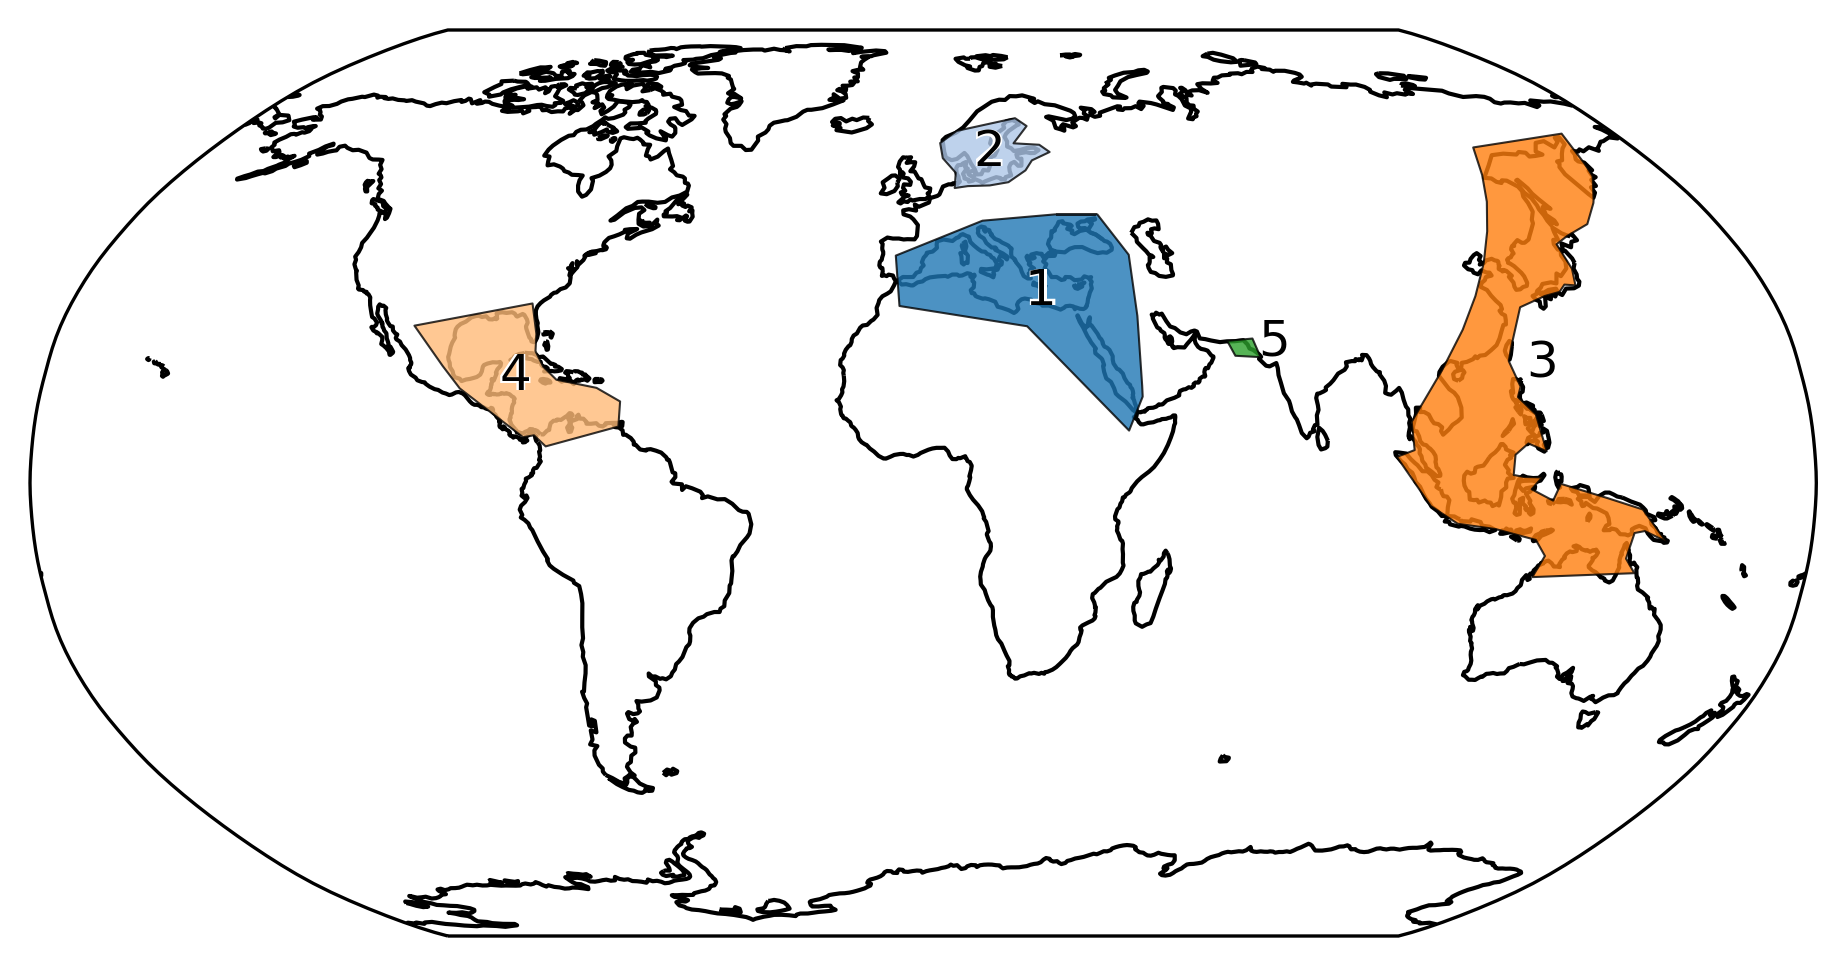

In [45]:
# Plot the special areas polygons on a map
plt.rcParams['figure.dpi'] = 300
from mask_polygons_utils import polygons_from_txt, load_polygons, to_mask
import cartopy.crs as ccrs
polygons = load_polygons(join(main_dir,'special_areas_polygons.shp'))
#Plot polygons colored and labelled by their index in the list polygons_with_GulfCaribbean
fig = plt.figure(figsize=(10,4)); ax = plt.axes(projection=ccrs.Robinson()); ax.coastlines()
for i, polygon in enumerate(polygons):
    ax.add_geometries([polygon], ccrs.PlateCarree(), facecolor=plt.cm.tab20(i), edgecolor='black', alpha=0.8, linewidth=0.5)
    print(i)
    if not i == 4:
        ax.text(polygon.centroid.x, polygon.centroid.y, str(i+1), horizontalalignment='center', verticalalignment='center', 
                transform=ccrs.PlateCarree(), color='white',
                fontsize=12, fontweight=1000)
        ax.text(polygon.centroid.x, polygon.centroid.y, str(i+1), horizontalalignment='center', verticalalignment='center', 
                transform=ccrs.PlateCarree(),
                fontsize=12, fontweight=100)
        
    else: # index 5 text should be next to the polygon, not in the center
        ax.text(polygon.centroid.x+6.5, polygon.centroid.y+1, str(i+1), horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                color='white',
                fontsize=12, 
                fontweight=1000)
        ax.text(polygon.centroid.x+6.5, polygon.centroid.y+1, str(i+1), horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                fontsize=12)


plt.show()